# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.   
In our repo these are simply under `/data`. There is a training, validation, and test json.  
We also add the imports cell.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk.tokenize.casual
from tqdm import tqdm
try:
    from spellchecker import SpellChecker
except ImportError:
    !pip install pyspellchecker
    from spellchecker import SpellChecker
try:
    from wordcloud import WordCloud
except ImportError:
    !pip install wordcloud
    from wordcloud import WordCloud
try:
    import umap
except ImportError:
    !pip install umap-learn
    import umap
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
import gensim
import gensim.downloader as gloader
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from typing import List, Dict
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, TimeDistributed, Masking, Lambda, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os
from transformers import TrainingArguments
from keras.callbacks import ReduceLROnPlateau
from transformers import EarlyStoppingCallback

2. **Load** the three JSON files and encode them as pandas dataframes.  
We interpret this as three separate dataframes, given the plural "s", but one dataframe with an index for training, validation, and test splits could lead to more concise code.

In [ ]:
train_df = pd.read_json('./data/training.json', orient='index')
val_df = pd.read_json('./data/validation.json', orient='index')
test_df = pd.read_json('./data/test.json', orient='index')

We check their size and content.

In [27]:
train_df.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6920 entries, 100001 to 203260
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_EXIST           6920 non-null   int64 
 1   lang               6920 non-null   object
 2   tweet              6920 non-null   object
 3   number_annotators  6920 non-null   int64 
 4   annotators         6920 non-null   object
 5   gender_annotators  6920 non-null   object
 6   age_annotators     6920 non-null   object
 7   labels_task1       6920 non-null   object
 8   labels_task2       6920 non-null   object
 9   labels_task3       6920 non-null   object
 10  split              6920 non-null   object
dtypes: int64(2), object(9)
memory usage: 648.8+ KB


We notice that the JSON dictionary ID is the same as id_EXIST. We can remove this redundancy later. Lets check how many examples were provided.

In [29]:
print(f"There are {len(train_df)} training samples, {len(val_df)} validation samples, and {len(test_df)} test samples.")

There are 6920 training samples, 726 validation samples, and 312 test samples.


3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.  
As of right now, a label is a collection of binary YES or NO answers to the type of sexism. For example:

In [30]:
train_labels = train_df['labels_task1']
val_labels = val_df['labels_task1']
test_labels = test_df['labels_task1']

train_labels.head()

100001    [YES, YES, NO, YES, YES, YES]
100002        [NO, NO, NO, NO, YES, NO]
100003         [NO, NO, NO, NO, NO, NO]
100004      [NO, NO, YES, NO, YES, YES]
100005     [YES, NO, YES, NO, YES, YES]
Name: labels_task1, dtype: object

To generate hard labels, we take the response assigned by the majority of the annotators. Out of curiosity, are there always 6 annotators in this dataset?

In [31]:
number_annotators = train_df['number_annotators']
number_annotators.describe()

count    6920.0
mean        6.0
std         0.0
min         6.0
25%         6.0
50%         6.0
75%         6.0
max         6.0
Name: number_annotators, dtype: float64

Yes there are always 6 annotators. We also checked val_df and test_df to make sure but removed the code since it has the same result. We now write a voting function and apply it to the labels Series.

In [32]:
def majority_vote(label):
    yes_count = label.count("YES")
    no_count = label.count("NO")
    return "REMOVE" if yes_count == no_count else "YES" if yes_count > no_count else "NO"

train_labels_hard = train_labels.apply(majority_vote)
val_labels_hard = val_labels.apply(majority_vote)
test_labels_hard = test_labels.apply(majority_vote)

train_labels_hard.head()

100001       YES
100002        NO
100003        NO
100004    REMOVE
100005       YES
Name: labels_task1, dtype: object

We integrate the hard labels into the Dataframes.

In [33]:
train_df['hard_label_task1'] = train_labels_hard
val_df['hard_label_task1'] = val_labels_hard
test_df['hard_label_task1'] = test_labels_hard

train_df.head(4)

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,hard_label_task1
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,YES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,NO
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,NO
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES,REMOVE


Finally, we remove the items without a clear majority.

In [34]:
train_df = train_df[train_df['hard_label_task1'] != "REMOVE"]
val_df = val_df[val_df['hard_label_task1'] != "REMOVE"]
test_df = test_df[test_df['hard_label_task1'] != "REMOVE"]

train_df.head(4)

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,hard_label_task1
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,YES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,NO
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,NO
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,YES


4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`. We can explore the spanish data at another time.

In [35]:
train_df = train_df[train_df['lang'] == 'en']
val_df = val_df[val_df['lang'] == 'en']
test_df = test_df[test_df['lang'] == 'en']

train_df.head(4)

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,6,"[Annotator_391, Annotator_392, Annotator_393, ...","[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, YES, NO, YES, YES]","[REPORTED, DIRECT, REPORTED, -, REPORTED, REPO...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION, MIS...",TRAIN_EN,YES
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,6,"[Annotator_397, Annotator_398, Annotator_399, ...","[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, NO, YES, NO, YES]","[REPORTED, REPORTED, -, REPORTED, -, JUDGEMENTAL]","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [STEREOTY...",TRAIN_EN,YES
200006,200006,en,According to a customer I have plenty of time ...,6,"[Annotator_409, Annotator_410, Annotator_411, ...","[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, YES, YES, YES, YES]","[REPORTED, REPORTED, REPORTED, REPORTED, REPOR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [S...",TRAIN_EN,YES
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",6,"[Annotator_415, Annotator_416, Annotator_417, ...","[F, F, M, M, M, F]","[18-22, 23-45, 18-22, 23-45, 46+, 46+]","[YES, YES, YES, YES, YES, YES]","[JUDGEMENTAL, REPORTED, REPORTED, DIRECT, DIRE...","[[STEREOTYPING-DOMINANCE], [STEREOTYPING-DOMIN...",TRAIN_EN,YES


5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.

In [36]:
train_df = train_df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
val_df = val_df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
test_df = test_df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,YES
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,YES
200006,200006,en,According to a customer I have plenty of time ...,YES
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",YES
200008,200008,en,New to the shelves this week - looking forward...,NO


6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [37]:
train_df['hard_label_task1'] = train_df['hard_label_task1'].replace({'NO': 0, 'YES': 1}).astype(int)
val_df['hard_label_task1'] = val_df['hard_label_task1'].replace({'NO': 0, 'YES': 1}).astype(int)
test_df['hard_label_task1'] = test_df['hard_label_task1'].replace({'NO': 0, 'YES': 1}).astype(int)

train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


We visualize the distribution.

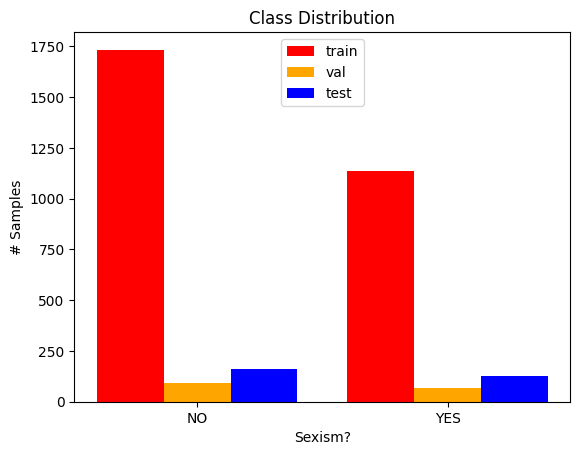

There are now 2870 training samples, 158 validation samples, and 286 test samples.


In [38]:
plt.hist([train_df.hard_label_task1.values, val_df.hard_label_task1.values, test_df.hard_label_task1.values], bins=2, label=['train', 'val', 'test'], color=["red", "orange", "blue"], align="mid")
plt.legend(loc='upper center')
plt.title('Class Distribution')
plt.xlabel('Sexism?')
plt.ylabel('# Samples')
plt.xticks(ticks=[0.25,0.75], labels=['NO', 'YES'])
plt.show()

print(f"There are now {len(train_df)} training samples, {len(val_df)} validation samples, and {len(test_df)} test samples.")

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

We investigate what the tweets look like before cleaning.

In [39]:
train_tweets = train_df['tweet']
val_tweets = val_df['tweet']
test_tweets = test_df['tweet']

for i in range(0,10):
    print(f"{i+1}: "+train_tweets.iloc[i])

1: Writing a uni essay in my local pub with a coffee. Random old man keeps asking me drunk questions when I'm trying to concentrate &amp; ends with "good luck, but you'll just end up getting married and not use it anyway". #EverydaySexism is alive and well 🙃
2: @UniversalORL it is 2021 not 1921. I dont appreciate that on two rides by myself your team member looked behind me and asked the man behind how many in my party. Not impressed #everydaysexism
3: According to a customer I have plenty of time to go spent the Stirling coins he wants to pay me with, in Derry. "Just like any other woman, I'm sure of it." #EveryDaySexism in retail.
4: So only 'blokes' drink beer? Sorry, but if you aren't a 'bloke' you drink wine apparently....... #EverydaySexism alive and well in @HayesAmbleside @MelissaCole @Shinybiscuit https://t.co/AP4GeusmOX
5: New to the shelves this week - looking forward to reading these books @malorieblackman @jenlynnbarnes  @EverydaySexism #readingforpleasure #newbooks https:

We will write a master function to clean the tweets. Some of the removals are more than one liners and better handled as a function. To start, we create deEmojify(). We thank [Stack Overflow](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python) for assembling the emoji characters we will remove. This and many other cleaning processes use the regex library.

In [40]:
def deEmojify(text):
    '''
    Removes emoji's from text with no blankspace insertion.
    Args:
        text (str): Text from source.
    Returns:
        text (str): Cleaned text with emoji's removed.
    '''
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

To correct spelling we use a library which we instantiate outside the function with the english dictionary. This is based on the spell checker from [Peter Norvig](https://norvig.com/spell-correct.html).

In [41]:
spell = SpellChecker(language='en')

def correct_spelling(text):
    '''
    Simple spell checker which operates word by word and does not modify words missing from dictionary.
    Args:
        text (str): Text from source.

    Returns:
        text (str): Spell corrected text.
    '''
    words = re.findall(r'\b\w+\b', text)
    corrected_text = ""
    for word in words:
        corrected_word = spell.correction(word)
        try:
            corrected_text = corrected_text + corrected_word + " "
        except:
            corrected_text = corrected_text + word + " "
    return corrected_text

To lemmatize the words, we use the NLTK libary and example from Tutorial 1 of the course.

In [42]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def lem_text(text: str):
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
    return " ".join(words)

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


To remove stopwords, which make the vocabulary noisy, we also use NLTK. We will keep "not" since it could be crucial to preserve the meaning of the tweet and then for classification task.

In [43]:
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

if 'not' in STOPWORDS:
    STOPWORDS.discard('not')
    print("'not' was removed from stopwords!")

'not' was removed from stopwords!


We remove hashtags but make an effort to keep the compound words associated, while separating them into their component words since these provide valuable data to the model. As root words, we use the GloVe embedding library.

In [44]:
embedding_dimension = 100 # choose between 50, 100, 200, 300
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
try:
        embedding_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e

vocab_set = set(embedding_model.key_to_index.keys())

def split_compound_word(word, vocab_set):
    """Splits a compound word into its components based on vocab_set if possible.
    Args:
        word (str): A word from source.
        vocab_set (set): A set of valid words for splitting.
    Returns:
        list or None: A list of split words if successful, otherwise None.
    """
    n = len(word)
    dp = [None] * (n + 1)
    dp[0] = []
    already_found = 0
    
    for i in range(1, n + 1):
        for j in range(already_found, i):
            substring = word[j:i]
    
            if dp[already_found] is not None and substring in vocab_set and len(substring) > 5:
    
                dp[i] = dp[already_found] + [substring]
                already_found = i
    
                break

    return dp[n] if dp[n] is not None else None

def extract_and_split_hashtags(text, vocab_set):
    """
    Extracts hashtags from a given text, attempts to split them into valid components
    based on a vocabulary set, and replaces the hashtags in the text with their split versions.

    Args:
        text (str): The input text containing hashtags.
        vocab_set (set): A set of valid words used to split compound hashtags.

    Returns:
        str: The modified text with hashtags replaced by their split components if possible.

    Example:
        >>> text = "#beautifulday #sunsetviews!"
        >>> vocab_set = {"beautiful", "day", "sunset", "views"}
        >>> extract_and_split_hashtags(text, vocab_set)
        'beautiful day sunset views!'
    """
    hashtagged_words = re.findall(r'#([a-zA-Z]+)', text)

    for word in hashtagged_words:
        split_result = split_compound_word(word.lower(), vocab_set)

        if split_result:
            
            text = text.replace(f"#{word}", " ".join(split_result))
        else:
            
            text = text.replace(f"#{word}", word)

    return text

For URLS we thank [Stack Overflow](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python) for a very robust example.
For the mention removal we credit the library NLTK which provides a [twitter aware tokenizer](https://www.nltk.org/_modules/nltk/tokenize/casual.html).
For special characters, we once more credit [Stack Overflow](https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string).

Now, we have built the function to clean our tweets, naming it bird bath since it cleans twitter messages. Follows its pipeline.

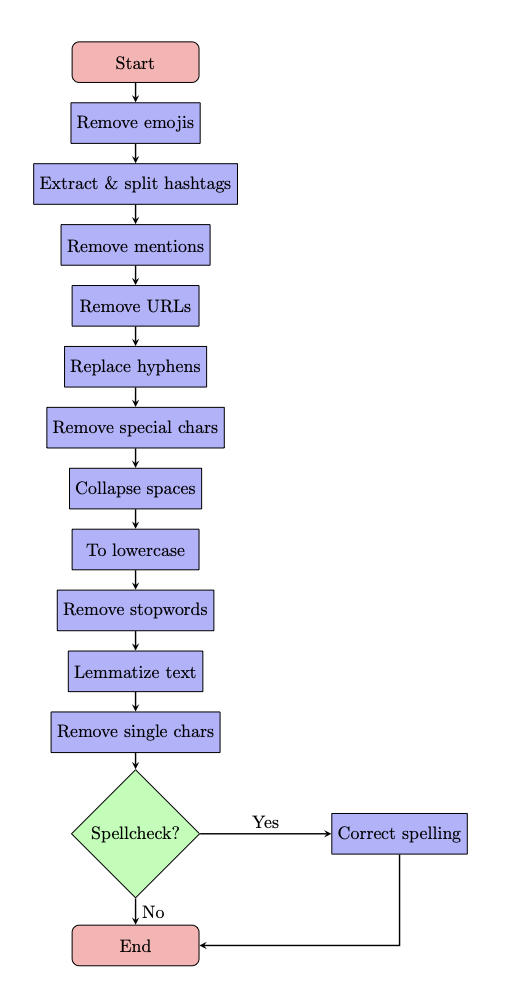
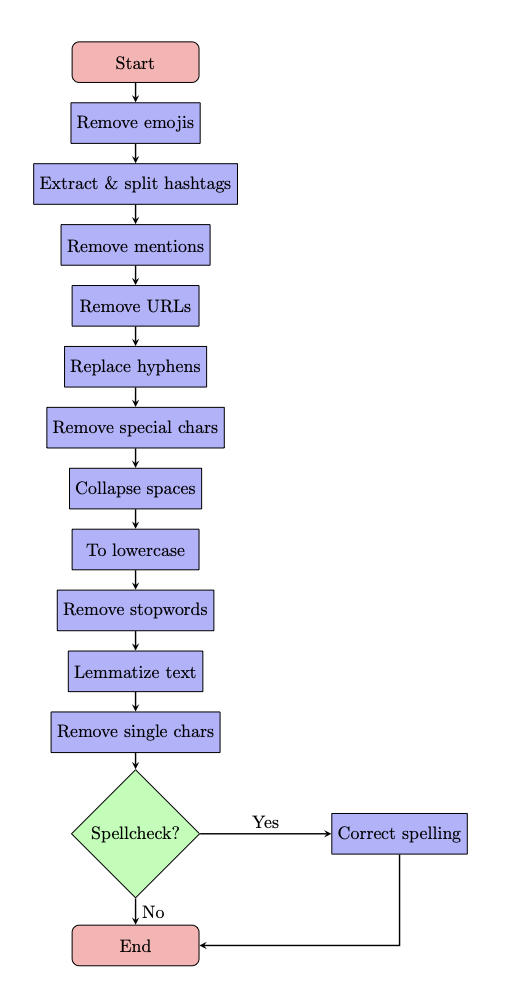
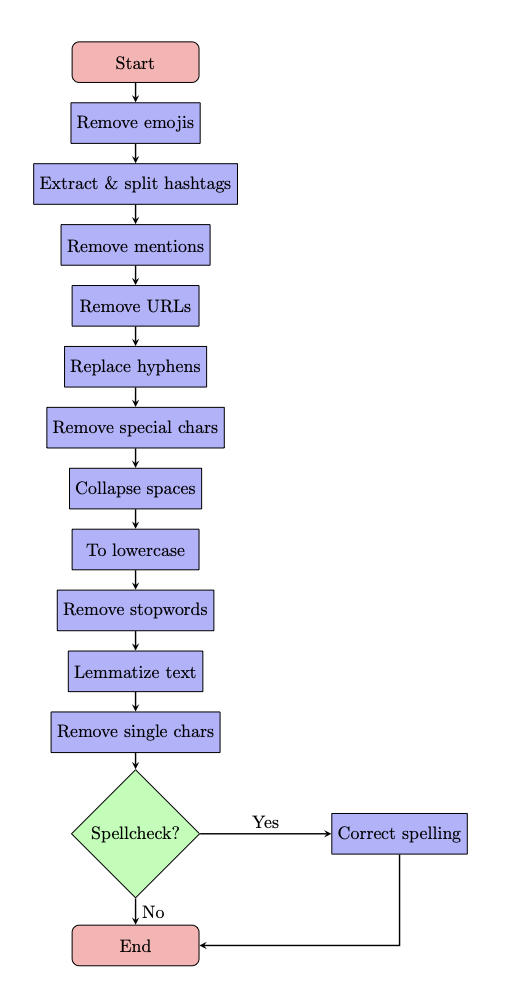
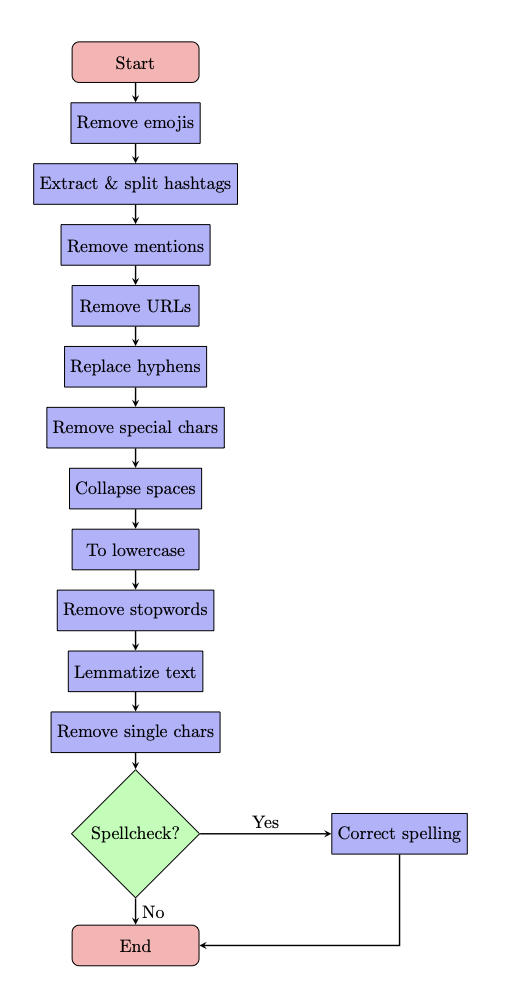
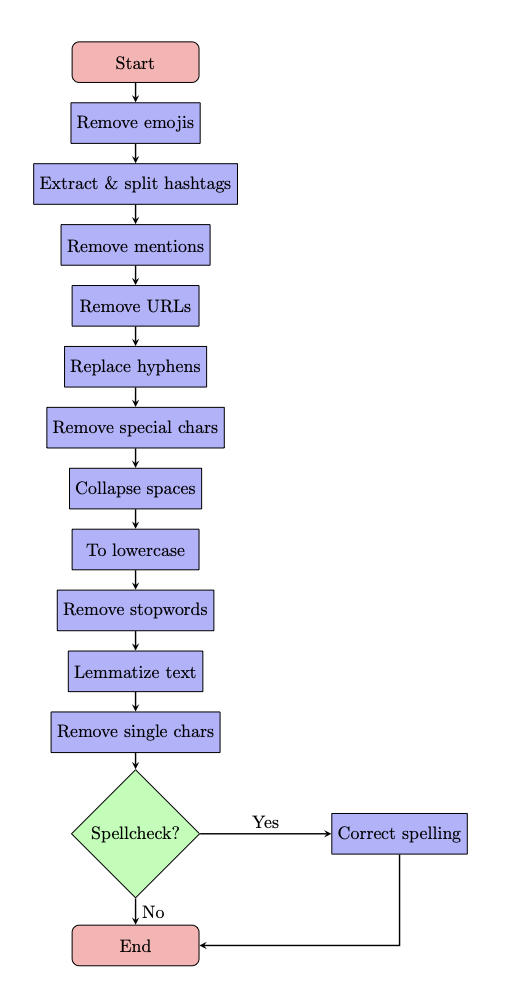
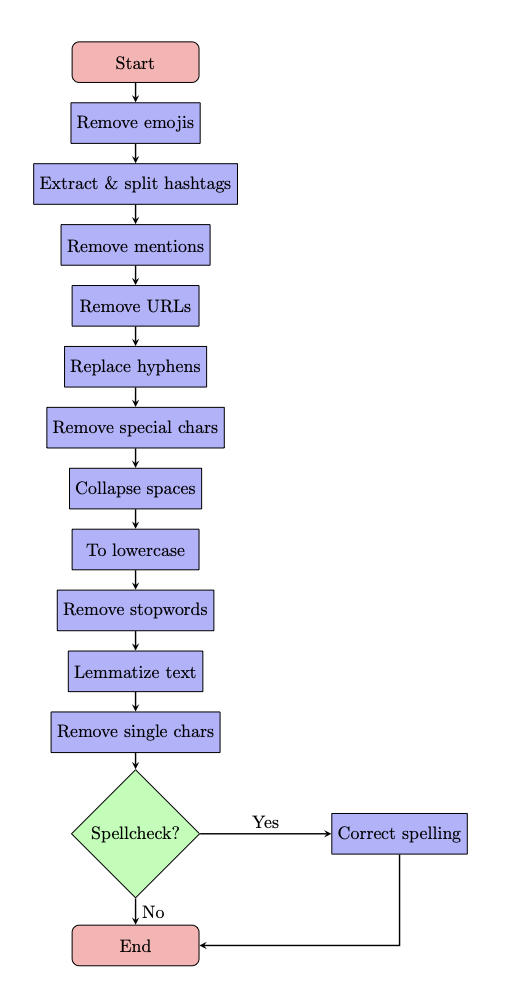

In [45]:
def bird_bath(text, spellcheck=False):
    text = deEmojify(text) # removes emojis
    text = extract_and_split_hashtags(text, vocab_set) # removes hashtags while keeping word since this provides salient info
    text = nltk.tokenize.casual.remove_handles(text) # removes mentions
    text = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', text) # removes URLS
    text = re.sub(r'(\w+)-(\w+)', r'\1 \2', text) # remove dash (hypen) and replace with blank space
    text = re.sub('[^A-Za-z0-9 ]+', '', text) # removes special characters, symbols, and quote characters and remove blank space
    text = re.sub('\s+', ' ', text) # replaces consecutive white space with a single whitespace
    text = text.lower() # replace text with lower case
    text = ' '.join([x for x in text.split() if x and x not in STOPWORDS]) # removes frequent words, aggressive
    text = lem_text(text) # lemmatize
    text = re.sub(r'\b[a-zA-Z]\b', '', text) # removes lonely characters e.g. " a "
    if spellcheck: text = correct_spelling(text) # spell checking, slow
    return text

We run this and investigate what the tweets look like after cleaning. This takes a while if spell checking, so we wrap it with a progress bar, and set that flag to False.

In [57]:
tqdm.pandas()

train_tweets = train_tweets.progress_apply(bird_bath, spellcheck=False)
val_tweets = val_tweets.progress_apply(bird_bath, spellcheck=False)
test_tweets = test_tweets.progress_apply(bird_bath, spellcheck=False)

for i in range(0,10):
    print(f"{i+1}: "+train_tweets.iloc[i])

100%|██████████| 286/286 [00:00<00:00, 748.30it/s]

1: write uni essay local pub coffee random old man keep ask drunk question im try concentrate amp end good luck youll end get marry not use anyway everyday sexism alive well
2: 2021 not 1921 dont appreciate two ride team member look behind ask man behind many party not impressed everyday sexism
3: accord customer plenty time go spent stirling coin want pay derry like woman im sure everyday sexism retail
4: bloke drink beer sorry arent bloke drink wine apparently everyday sexism alive well
5: new shelf week look forward read book readin pleasure newbooks
6: guess thats fairly normal neanderthal
7: everyday sexism mean woman usually end low pay support work start change traditionalist notice unfairness previously hasnt bother
8: hi orla interest piece 2 policy response believe early inlife prosecution punishment way go boy young men offend girl woman see zero tolerance approach institute
9: everyday sexism dear godcolette capable identify sexism literally anywheregood see develop female 

Our efforts have made a huge improvement to the quality of the data! We put the cleaned twitter text back in its respective Dataframes. We believe that making all words lowercase reduced the size of the vocabulary while not impacting the saliency much. We can get away with this because we are not performing part of speech tagging. We also decided to remove stopwords, which are common words which add noise to the data as per the second tutorial in NLP course. The only exception is "not" since this frequent word provides useful information to the classifier.

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

We have done text preprocessing to avoid spurious data and space splitting should work correctly. We now perform tokenization, which decides the granularity and exclusively defines the vocabulary. We consider the words as the atomic units in this case. Each word should be recognized and assigned an index. We will make sure, and the tools help us, to have a process which always creates a reproducible vocabulary. For comparison's sake, we tokenize without data cleaning first.

In [58]:
tokenizer = Tokenizer(oov_token="<UNK>") 

for text in tqdm(train_df['tweet'], desc="Tokenizing"): 
    tokenizer.fit_on_texts([text])

word_index = tokenizer.word_index 
print(f"Our vocabulary has {len(word_index)} tokens!")

Tokenizing: 100%|██████████| 2870/2870 [00:41<00:00, 68.75it/s] 

Our vocabulary has 16876 tokens!


Now we update our dataframes with the cleaned text and tokenize once more.

In [59]:
train_df['tweet'] = train_tweets
val_df['tweet'] = val_tweets
test_df['tweet'] = test_tweets

In [60]:
tokenizer = Tokenizer(oov_token="<UNK>") 

for text in tqdm(train_df['tweet'], desc="Tokenizing"): 
    tokenizer.fit_on_texts([text])

word_index = tokenizer.word_index 
print(f"Our vocabulary has {len(word_index)} tokens!")

Tokenizing: 100%|██████████| 2870/2870 [00:24<00:00, 115.83it/s]

Our vocabulary has 10274 tokens!


The vocabulary had a stunning 16876 tokens compared to 10275 for the second! Therefore this cleaning step has reduced the size by nearly 40 percentage points! The '0' index will be reserved for padding.

We create a word cloud based on the word frequencies to investigate the most common words in the vocabulary.

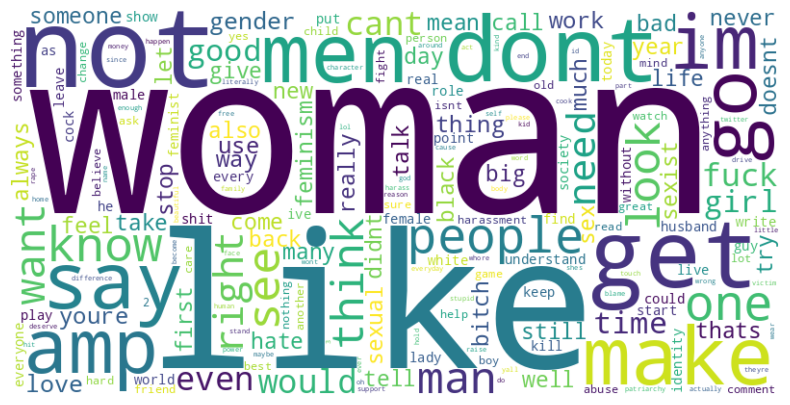

In [61]:
word_counts = tokenizer.word_counts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Now it would be time to select our embedding dimension and download the **GloVe embeddings**. These are a type of dense embedding as opposed to Bag-of-Words (BoW) which is an example of a sparse embedding. We thank NLP Tutorial 2 for their help. However, we already did this earlier to help us clean the text.  
We need to check for OOV terms and assign them an embedding. What percentage of our vocabulary is OOV?

In [62]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Identifies out-of-vocabulary (OOV) terms by comparing a dataset-specific vocabulary
    with the vocabulary of a pre-trained embedding model.

    Args:
        embedding_model (gensim.models.keyedvectors.KeyedVectors):
            The pre-trained word embedding model (Gensim wrapper).
        word_listing (List[str]):
            The dataset-specific vocabulary.

    Returns:
        List[str]: A list of terms from the dataset vocabulary that are not present
        in the embedding model's vocabulary.
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

oov_terms = check_OOV_terms(embedding_model, word_index)
oov_percentage = float(len(oov_terms)) * 100 / len(word_index)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

for i in range(10):
    print(f"{i+1}: {oov_terms[i]}")

Total OOV terms: 2182 (21.24%)
1: twilightjust
2: deportedthey
3: workschool
4: friedanbookstagrambookstagrammerqotdgoodreadsreader
5: pussyfirst
6: 55k
7: autist
8: ironyshe
9: experienceare
10: cryptocurrency


This is higher than we expected, so we print some to see. This demonstrates the difficulty of data cleaning, since these cases show different flaws in our approach. The words might be a misspelling or did not get separated as compound words...


Now to assign our vocabulary tokens to their embeddings. We assign random vectors to tokens not in GloVe. We credit Tutorial 2 for its help on the **build_embedding_matrix** function. We measure the standard deviation of our GloVe vocabulary to use for the randomized tokens.

In [63]:
def find_std(embedding_model):
    """
    Computes and prints statistical metrics for the embedding vectors in a given embedding model,
    including the minimum, maximum, mean, standard deviation, and median values.

    Args:
        embedding_model (gensim.models.keyedvectors.KeyedVectors):
            A pre-trained word embedding model (e.g., GloVe, Word2Vec).

    Returns:
        float: The standard deviation of the embedding vectors.
    """
    embedding_vectors = np.array([embedding_model[word] for word in vocab_set])

    min_value = np.min(embedding_vectors)
    max_value = np.max(embedding_vectors)
    mean_value = np.mean(embedding_vectors)
    std_deviation = np.std(embedding_vectors)
    median_value = np.median(embedding_vectors)

    print(f"Statistics for GloVe embeddings (dimension {embedding_dimension}):")
    print(f"Min: {min_value}")
    print(f"Max: {max_value}")
    print(f"Mean: {mean_value}")
    print(f"Standard Deviation: {std_deviation}")
    print(f"Median: {median_value}")
    return std_deviation

In [64]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int)-> np.ndarray:
    """
    Constructs an embedding matrix for a dataset-specific vocabulary using a pre-trained embedding model.

    Args:
        embedding_model (gensim.models.keyedvectors.KeyedVectors):
            A pre-trained word embedding model (e.g., GloVe, Word2Vec).
        embedding_dimension (int):
            The dimensionality of the word embeddings.
        word_to_idx (Dict[str, int]):
            A mapping from words to their corresponding indices in the dataset vocabulary.
        vocab_size (int):
            The total size of the vocabulary, including space for an unknown token.

    Returns:
        np.ndarray:
            An embedding matrix of shape `(vocab_size, embedding_dimension)`, where each row corresponds to
            the embedding vector for a word in the dataset vocabulary. Words not found in the embedding model
            are assigned random vectors sampled from a uniform distribution. (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    std = find_std(embedding_model)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-std, high=std, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_index, len(word_index)+1) # The +1 leaves space for embedding_matrix[0] = UNK
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Statistics for GloVe embeddings (dimension 100):
Min: -4.0665998458862305
Max: 3.575000047683716
Mean: 0.00445199990645051
Standard Deviation: 0.4081575870513916
Median: 0.005431499797850847


100%|██████████| 10274/10274 [00:00<00:00, 241958.24it/s]

Embedding matrix shape: (10275, 100)


We check our matrix is full of embeddings. Only the UNK token should be all zero.

In [65]:
for i, embedding in enumerate(embedding_matrix):
    if np.all(embedding == 0):
        print(f"Embedding at index {i} is a zero vector.")

Embedding at index 0 is a zero vector.


We will now visualize our pre-trained embeddings!

Running UMAP reduction method... (it may take a while...)
UMAP reduction completed!
Annotating words: ['woman', 'girl', 'lady', 'gentleman', 'boy', 'man', 'bitch', 'pregnancy', 'fuck', 'cunt']


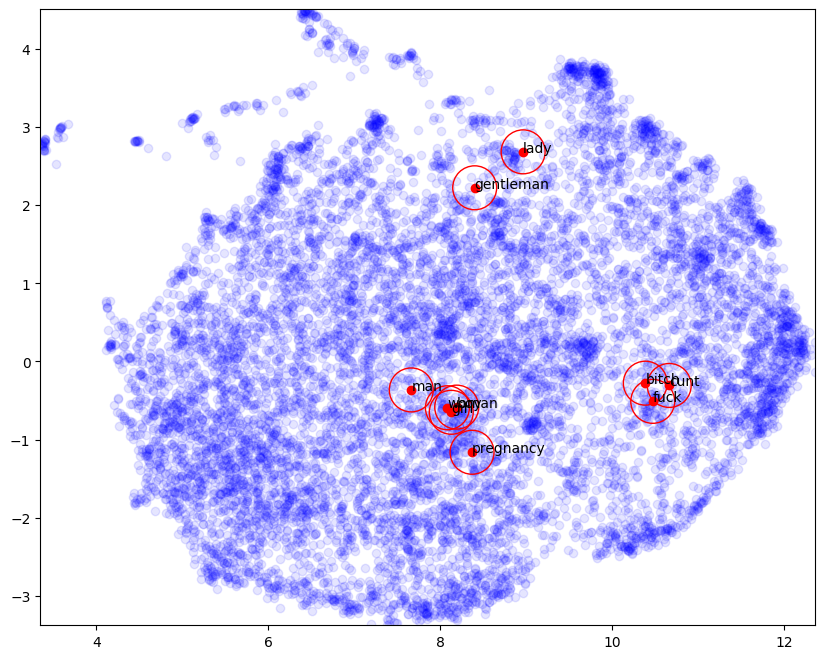

In [137]:
def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Reduces the dimensionality of high-dimensional embeddings using UMAP.

    Args:
        embeddings (np.ndarray):
            A 2D NumPy array of shape `(n_samples, n_features)` representing the input embeddings.

    Returns:
        np.ndarray:
            A 2D NumPy array of shape `(n_samples, 2)` containing the reduced embeddings.
    """
    print("Running UMAP reduction method... (it may take a while...)")
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)
    print("UMAP reduction completed!")

    return reduced

def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Visualizes 2D embeddings using a scatter plot, with optional annotations for specific words.

    Args:
        embeddings (np.ndarray):
            A 2D NumPy array of shape `(n_samples, 2)` representing reduced embeddings (e.g., via UMAP).
        word_annotations (List[str], optional):
            A list of words to highlight and annotate on the plot. Defaults to None.
        word_to_idx (Dict[str, int], optional):
            A mapping from words to their corresponding indices in the vocabulary. Required if
            `word_annotations` is provided. Defaults to None.
    Notes:
        - Words in `word_annotations` that are not present in `word_to_idx` will raise a KeyError.
        - Outliers in the embeddings are handled by adjusting axis limits for better visualization.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])

reduced_embedding_umap = reduce_umap(embedding_matrix)
visualize_embeddings(reduced_embedding_umap, ['woman', 'girl', 'lady', 'gentleman', 'boy', 'man', 'bitch', 'pregnancy', 'fuck', 'cunt'], word_index)

plt.show()

Running UMAP several times, since it is stochastic, we see the embeddings for 'girl' and 'woman' are always nearby and 'lady' less so. We must assume that the context in which 'lady' appears is different from the others. To test this, we also plot 'gentleman' since it has an intuitive similarity to 'lady'. We see in some cases it is near 'lady' but in other runs it is by itself or near 'girl' and woman'.

Either way, our embeddings are complete and there is a clear cluster of sexist (female slur) words.

# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier. This includes a Baseline LSTM and a Model 1 LSTM.

To see how difficult the problem is, we go one step further and we start by defining a random majority baseline. This is useful to compare to the models we will train.

In [66]:
train_labels = train_df['hard_label_task1'].values
val_labels = val_df['hard_label_task1'].values
test_labels = test_df['hard_label_task1'].values

most_frequent_class = np.bincount(train_labels).argmax()
majority_preds = np.full_like(train_labels, most_frequent_class)
baseline_accuracy = accuracy_score(train_labels, majority_preds)
print(f'Majority Baseline Accuracy: {baseline_accuracy * 100:.2f}%')

Majority Baseline Accuracy: 60.38%


We see it is about 60% which makes sense since the classes are slightly unbalanced and this is a binary classification problem, so at worse the classifier would have accuracy 1/2 or 50\%.

### Token to embedding mapping using an Embedding layer!
Steps:

1) Extract the cleaned tweets from their dataframes as lists
2) Tokenize the tweets into sequences
3) Decide the length of padding
4) Pad the sequences
5) Return the padded sequences, ready to be used by the embedding layer of the model

In [67]:
def maxlength(dfs, tokenizer):
    """
    Determines the maximum length of tokenized sequences across multiple dataframes.

    Args:
        dfs (list): List of dataframes containing tweets.
        tokenizer: Tokenizer to convert text to sequences.

    Returns:
        int: Maximum length of tokenized sequences.
    """
    max_length = 0
    for df in dfs:
        tweets = df['tweet'].tolist()
        tokenized_tweets = tokenizer.texts_to_sequences(tweets)
        for tweet in tokenized_tweets:
            tweet_length = len(tweet)
            if tweet_length > max_length:
                max_length = tweet_length
    return max_length

def tokenandpad(df, tokenizer, max_length):
    """
    Tokenizes and pads a dataframe of tweets to a consistent length.

    Args:
        df (pd.DataFrame): DataFrame containing tweets.
        tokenizer: Tokenizer to convert text to sequences.
        max_length (int): Maximum length for padding.

    Returns:
        np.ndarray: Padded tokenized sequences.
    """
    tweets = df['tweet'].tolist()
    tokenized_tweets = tokenizer.texts_to_sequences(tweets)
    padded_tokenized_tweets = pad_sequences(tokenized_tweets, padding='post', maxlen=max_length)
    return padded_tokenized_tweets

max_length = maxlength([train_df, val_df, test_df], tokenizer)
print(f"Maximum length for padding: {max_length}")

x_train = tokenandpad(train_df, tokenizer, max_length)
x_val = tokenandpad(val_df, tokenizer, max_length)
x_test = tokenandpad(test_df, tokenizer, max_length)

print(f"Data shapes: {x_train.shape}, {x_val.shape}, {x_test.shape}")
print(f"Tokenized training example: {x_train[0]}")

Maximum length for padding: 36
Data shapes: (2870, 36), (158, 36), (286, 36)
Tokenized training example: [  81 3819 1283 1506 3820 1284 1113  125   18   91  117 1507  300   12
   53 3821   11  157   27 1114  553  157    5  512    4   33  822  201
  212  581   37    0    0    0    0    0]


In [68]:
def count_unk_tokens(data, tokenizer):
    """
    Count the number of <UNK> tokens in a tokenized dataset.

    Args:
        data (np.ndarray): Tokenized and padded data (sequences of token indices).
        tokenizer: The tokenizer used for tokenization, which includes <UNK> token handling.

    Returns:
        int: The number of <UNK> tokens found in the data.
    """
    unk_index = tokenizer.word_index.get('<UNK>', 0)  
    unk_count = np.sum(data == unk_index)  
    return unk_count

train_unk_count = count_unk_tokens(x_train, tokenizer)
val_unk_count = count_unk_tokens(x_val, tokenizer)
test_unk_count = count_unk_tokens(x_test, tokenizer)

print(f"Number of <UNK> tokens in the training set: {train_unk_count}")
print(f"Number of <UNK> tokens in the validation set: {val_unk_count}")
print(f"Number of <UNK> tokens in the test set: {test_unk_count}")

Number of <UNK> tokens in the training set: 0
Number of <UNK> tokens in the validation set: 403
Number of <UNK> tokens in the test set: 690


The embedding layer will have an output shape (batch_size, sequence_length, embedding_dimension).

### Padding
Your model **should not** be penalized on those tokens.
We set mask_zero to True to tell the model to ignore padding tokens (tokens with a value of 0).

## Baseline
Implement a Bidirectional LSTM with a Dense layer on top.

In [70]:
def create_baseline(max_length, tokenizer, embedding_matrix, embedding_dimension):
    model = Sequential(name='Baseline_LSTM')

    model.add(Input(shape=(max_length,)))

    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dimension,
                        weights=[embedding_matrix],
                        trainable=False,
                        mask_zero=True))
    model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [71]:
baseline = create_baseline(max_length, tokenizer, embedding_matrix, embedding_dimension)
baseline.summary()

Model: "Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 36, 100)             │       1,027,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,112,109 (4.24 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 1,027,500 (3.92 MB)

# Model 1
Add an additional LSTM layer to the Baseline model

In [72]:
def create_model1(max_length, tokenizer, embedding_matrix, embedding_dimension):
    model = Sequential(name='Model_1_LSTM')
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dimension,
                        weights=[embedding_matrix],
                        trainable=False,
                        mask_zero=True))

    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)))
    model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model

In [73]:
model1 = create_model1(max_length, tokenizer, embedding_matrix, embedding_dimension)
model1.summary()

Model: "Model_1_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 36, 100)             │       1,027,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 36, 128)             │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,210,925 (4.62 MB)

 Trainable params: 183,425 (716.50 KB)

 Non-trainable params: 1,027,500 (3.92 MB)

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [74]:
epochs = 25
batch_size = 8

In [75]:
def evaluate_model(predictions, labels, verbose=False):
    f1_macro = f1_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    if verbose:
        print(f"Model Evaluation:")
        print(f"F1-Score (Macro): {f1_macro:.4f}")
        print(f"Accuracy: {accuracy:.4f}")

    return {
        'f1_score_macro': f1_macro,
        'accuracy': accuracy
    }


In [76]:
import random
import tensorflow as tf
seeds = [42, 123, 456]
baseline_weights = []
model1_weights = []

In [104]:
for i, seed in enumerate(seeds):

    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    baseline = create_baseline(max_length, tokenizer, embedding_matrix, embedding_dimension)

    print('')
    print(f'******** Seed {seed} ********')
    early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', mode='min')
    baseline_history = baseline.fit(
        x_train,
        np.array(train_labels),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        validation_data=(x_val, np.array(val_labels),),
        verbose=2
    )
    print('------ Evaluation ------')
    print('The Baseline model evaluation: ')
    pred = baseline.predict(x_val) 
    pred_binary = (pred >= 0.5).astype(int) 
    _ = evaluate_model(pred_binary.flatten(), np.array(val_labels), verbose=True)

    baseline.save_weights(f"/kaggle/working/baseline-{seed}.weights.h5")
    baseline_weights.append(baseline.get_weights())


******** Seed 42 ********
Epoch 1/25
359/359 - 15s - 43ms/step - accuracy: 0.6854 - loss: 0.5911 - val_accuracy: 0.7468 - val_loss: 0.5452
Epoch 2/25
359/359 - 10s - 29ms/step - accuracy: 0.7429 - loss: 0.5146 - val_accuracy: 0.7532 - val_loss: 0.5008
Epoch 3/25
359/359 - 10s - 29ms/step - accuracy: 0.7648 - loss: 0.4827 - val_accuracy: 0.7532 - val_loss: 0.4770
Epoch 4/25
359/359 - 10s - 29ms/step - accuracy: 0.7920 - loss: 0.4459 - val_accuracy: 0.6899 - val_loss: 0.5346
Epoch 5/25
359/359 - 10s - 29ms/step - accuracy: 0.8153 - loss: 0.4177 - val_accuracy: 0.7089 - val_loss: 0.5003
Epoch 6/25
359/359 - 10s - 29ms/step - accuracy: 0.8289 - loss: 0.3881 - val_accuracy: 0.7532 - val_loss: 0.4716
Epoch 7/25
359/359 - 10s - 29ms/step - accuracy: 0.8540 - loss: 0.3473 - val_accuracy: 0.7658 - val_loss: 0.4760
Epoch 8/25
359/359 - 10s - 29ms/step - accuracy: 0.8662 - loss: 0.3097 - val_accuracy: 0.7468 - val_loss: 0.4922
Epoch 9/25
359/359 - 10s - 29ms/step - accuracy: 0.8857 - loss: 0.284

In [77]:
for i, seed in enumerate(seeds):

    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    model1 = create_model1(max_length, tokenizer, embedding_matrix, embedding_dimension)

    print('')
    print(f'******** Seed {seed} ********')
    early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', mode='min')
    model1_history = model1.fit(
        x_train,
        np.array(train_labels),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        validation_data=(x_val, np.array(val_labels))
    )
    print('------ Evaluation ------')
    print('The Model1 model evaluation: ')
    pred = model1.predict(x_val) 
    pred_binary = (pred >= 0.5).astype(int)
    _ = evaluate_model(pred_binary.flatten(), np.array(val_labels), verbose=True)

    model1.save_weights(f"/kaggle/working/model1-{seed}.weights.h5")
    model1_weights.append(model1.get_weights())


******** Seed 42 ********
Epoch 1/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.6518 - loss: 0.6217 - val_accuracy: 0.7658 - val_loss: 0.5244
Epoch 2/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.7548 - loss: 0.5255 - val_accuracy: 0.7785 - val_loss: 0.4761
Epoch 3/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7583 - loss: 0.5021 - val_accuracy: 0.7722 - val_loss: 0.4774
Epoch 4/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7747 - loss: 0.4805 - val_accuracy: 0.8038 - val_loss: 0.4251
Epoch 5/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.7987 - loss: 0.4498 - val_accuracy: 0.8038 - val_loss: 0.4092
Epoch 6/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.7989 - loss: 0.4307 - val_accuracy: 0.8038 - val_loss: 0.3974
Epoch 7/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.8227 - loss: 0.3960 - val_accuracy: 0.7848 - val_loss: 0.4018
Epoch 8/25
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accurac

Both model seems to be consistent with different seeds. Evaluation on Test Set of best model will be done for the model1 with seed 456, which gave us the best result on validation set.  

In [79]:
best_LSTM = create_model1(max_length, tokenizer, embedding_matrix, embedding_dimension)
best_LSTM.set_weights(model1_weights[-1])
pred = best_LSTM.predict(x_test) 
pred_binary = (pred >= 0.5).astype(int)
_ = evaluate_model(pred_binary.flatten(), np.array(test_labels), verbose=True)

best_LSTM.save("bestLSTM.keras") 

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
Model Evaluation:
F1-Score (Macro): 0.7492
Accuracy: 0.7517


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

We first load the tokenizer and the model. We set 2 labels since it's a binary classifier, moreover labels are renamed and adapted for sexism detection.

In [81]:
model_card = 'cardiffnlp/twitter-roberta-base-hate'

tokenizer = AutoTokenizer.from_pretrained(model_card)
model = AutoModelForSequenceClassification.from_pretrained(model_card,
                                                           num_labels=2,
                                                           id2label={0: 'not sexist', 1: 'sexist'},
                                                           label2id={'not sexist': 0, 'sexist': 1})

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Let's print the model and its configurations.

In [82]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [83]:
print(model.config)

RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-hate",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "not sexist",
    "1": "sexist"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "not sexist": 0,
    "sexist": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



We then tokenize all the tweets using the standard max_length parameter, truncating tweets that exceed this maximum length. Based on the model configuration, which specifies "max_position_embeddings": 514, we set max_length = 512. This allows the tokenizer to handle the two additional tokens (\<s> and \</s>) reserved for special purposes.

In [84]:
def preprocess_text(text, tokenizer, max_length = 512):
    return tokenizer(text, max_length=max_length, truncation=True, padding=True)

In [86]:
!pip install datasets
from datasets import Dataset

tokenized_tweets_train = [preprocess_text(val, tokenizer) for val in train_df['tweet']]
tokenized_tweets_val = [preprocess_text(val, tokenizer) for val in val_df['tweet']]
tokenized_tweets_test = [preprocess_text(val, tokenizer) for val in test_df['tweet']]

Let's first encode our dataset including attention_mask and labels to fine tune the model, *datasets* library will be used to improve efficiency.

In [87]:
transformer_train_dataset = Dataset.from_dict({
    'input_ids': [item['input_ids'] for item in tokenized_tweets_train],
    'attention_mask': [item['attention_mask'] for item in tokenized_tweets_train],
    'labels': [item for item in train_df["hard_label_task1"]]
})
transformer_val_dataset = Dataset.from_dict({
    'input_ids': [item['input_ids'] for item in tokenized_tweets_val],
    'attention_mask': [item['attention_mask'] for item in tokenized_tweets_val],
    'labels': [item for item in val_df["hard_label_task1"]]
})
transformer_test_dataset = Dataset.from_dict({
    'input_ids': [item['input_ids'] for item in tokenized_tweets_test],
    'attention_mask': [item['attention_mask'] for item in tokenized_tweets_test],
    'labels': [item for item in test_df["hard_label_task1"]]
})

A sanity check is done to be sure the tokenization is working correctly. 

In [95]:
print(train_df['tweet'].tolist()[0])

write uni essay local pub coffee random old man keep ask drunk question im try concentrate amp end good luck youll end get marry not use anyway everyday sexism alive well


In [96]:
print(tokenizer.decode(tokenized_tweets_train[0]['input_ids']))

<s>write uni essay local pub coffee random old man keep ask drunk question im try concentrate amp end good luck youll end get marry not use anyway everyday sexism alive well</s>


We need to load metrics used for the evaluation of the model.

In [98]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

We then need to configure the arguments to specify the training settings required for fine-tuning the model.

In [106]:


early_stop_callback = EarlyStoppingCallback(early_stopping_patience=8)

training_args = TrainingArguments(
    output_dir="test_dir",                 
    learning_rate=5.e-5,
    per_device_train_batch_size=8,         
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",           
    save_strategy="epoch",                 
    load_best_model_at_end=True,
    report_to='none',                      
    metric_for_best_model="eval_loss",
    lr_scheduler_type='linear'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [107]:
from transformers import Trainer
import numpy as np


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=transformer_train_dataset,
    eval_dataset=transformer_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stop_callback],
)

In [109]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.381985,0.881203,0.886076
2,0.361700,0.523367,0.894947,0.898734
3,0.178600,0.674446,0.869313,0.873418
4,0.178600,0.831587,0.876130,0.879747
5,0.040200,0.941578,0.850692,0.854430


TrainOutput(global_step=1795, training_loss=0.1655249502665485, metrics={'train_runtime': 4076.4251, 'train_samples_per_second': 3.52, 'train_steps_per_second': 0.44, 'total_flos': 300754436272560.0, 'train_loss': 0.1655249502665485, 'epoch': 5.0})

Let's now evaluate the fine-tuned model on the test set.

In [142]:
transformer_predictions = trainer.predict(transformer_test_dataset)

In [114]:
metrics = compute_metrics([transformer_predictions.predictions, transformer_test_dataset['labels']])

print("F1 Score:", round(metrics['f1'],4))
print("Accuracy:", round(metrics['acc'],4))

F1 Score: 0.8028
Accuracy: 0.8042


In [117]:
model.save_pretrained("/kaggle/working/RoBERTa")

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



Let's start analyzing the result from the best model1 and from the Transformer model. Below the confusion matrices of the two models.

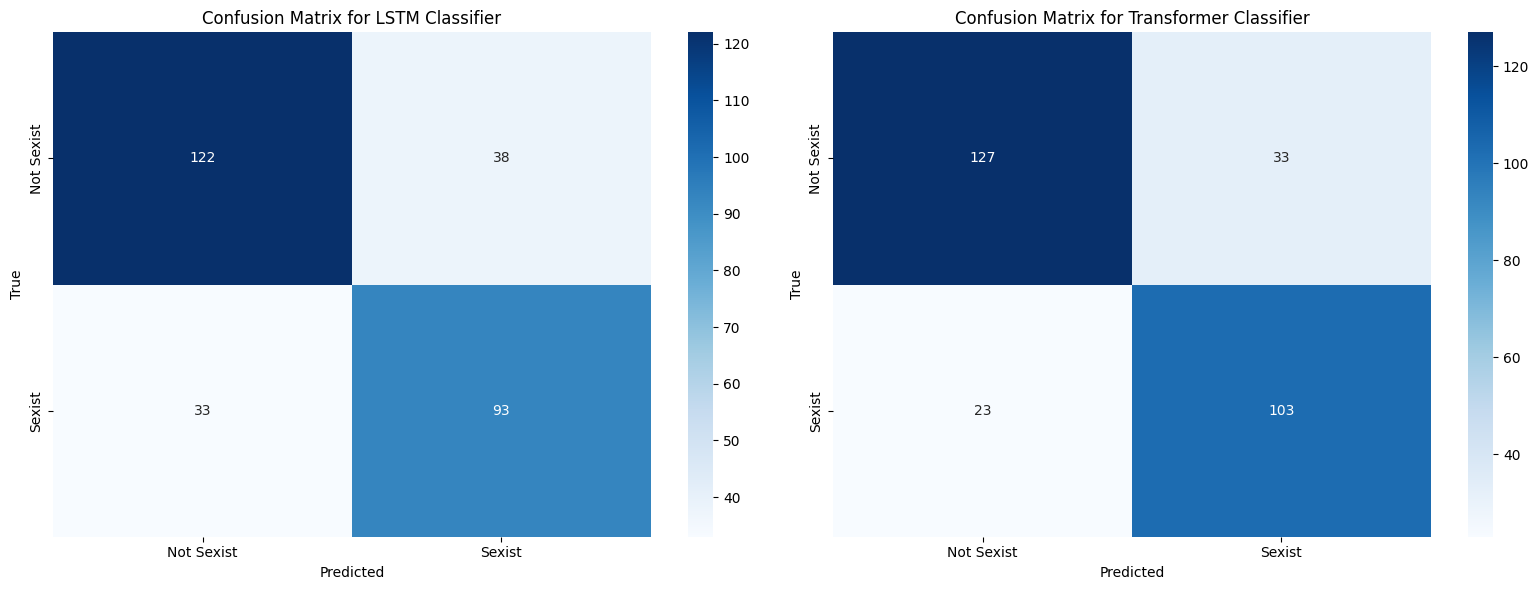

In [143]:
cm_lstm = confusion_matrix(np.array(test_labels), pred_binary.flatten())
transformer_predictions = np.argmax(transformer_predictions.predictions, axis=-1).tolist()
cm_transformer = confusion_matrix(np.array(test_labels), transformer_predictions)


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sexist', 'Sexist'], yticklabels=['Not Sexist', 'Sexist'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Classifier')

plt.subplot(1, 2, 2)
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sexist', 'Sexist'], yticklabels=['Not Sexist', 'Sexist'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Transformer Classifier')

plt.tight_layout()  
plt.show()

Let's then show the reports.

In [130]:
from sklearn.metrics import classification_report

print("Classification Report for LSTM Classifier:")
print(classification_report(np.array(test_labels), pred_binary.flatten(), target_names=['NO', 'YES']))

print("Classification Report for Transformer Classifier:")
print(classification_report(np.array(test_labels), transformer_predictions, target_names=['NO', 'YES']))


Classification Report for LSTM Classifier:
              precision    recall  f1-score   support

          NO       0.79      0.76      0.77       160
         YES       0.71      0.74      0.72       126

    accuracy                           0.75       286
   macro avg       0.75      0.75      0.75       286
weighted avg       0.75      0.75      0.75       286

Classification Report for Transformer Classifier:
              precision    recall  f1-score   support

          NO       0.85      0.79      0.82       160
         YES       0.76      0.82      0.79       126

    accuracy                           0.80       286
   macro avg       0.80      0.81      0.80       286
weighted avg       0.81      0.80      0.80       286



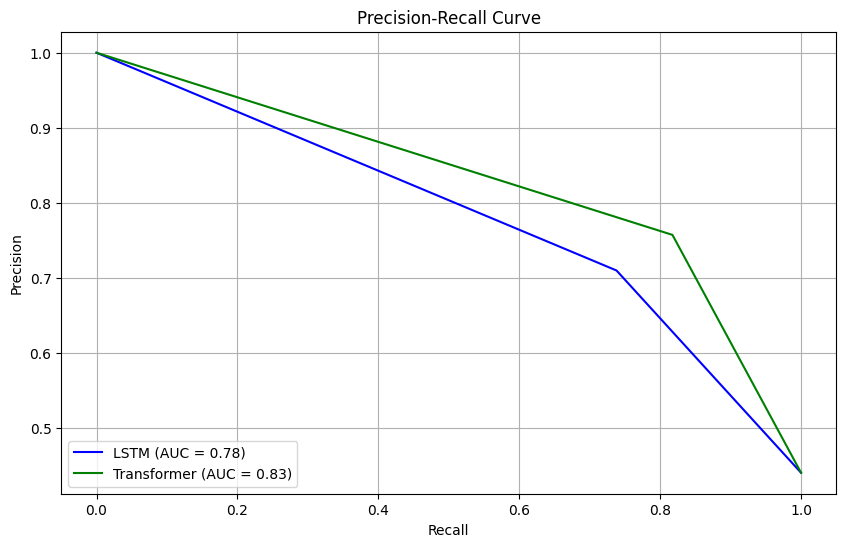

In [131]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(test_labels, pred_binary.flatten())
pr_auc_lstm = auc(recall_lstm, precision_lstm)

precision_transformer, recall_transformer, thresholds_transformer = precision_recall_curve(test_labels, transformer_predictions)
pr_auc_transformer = auc(recall_transformer, precision_transformer)

plt.figure(figsize=(10, 6))
plt.plot(recall_lstm, precision_lstm, label=f'LSTM (AUC = {pr_auc_lstm:.2f})', color='blue')
plt.plot(recall_transformer, precision_transformer, label=f'Transformer (AUC = {pr_auc_transformer:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


The confusion matrices and classification reports highlight that the Transformer model (RoBERTa) outperformed the LSTM model (with GloVe embeddings) in sexism classification. The Transformer achieved higher overall accuracy (80% vs. 75%) and demonstrated better precision and recall for both classes. For the "Not Sexist" class, the Transformer had higher precision (0.85 vs. 0.79) and comparable recall (0.79 vs. 0.76), while for the "Sexist" class, it showed substantial improvements in both precision (0.76 vs. 0.71) and recall (0.82 vs. 0.74). This indicates that the Transformer is better at identifying both sexist and non-sexist tweets, with fewer false positives and false negatives. Additionally, the weighted average f1-scores (0.80 for the Transformer vs. 0.75 for the LSTM) emphasize the Transformer's ability to capture contextual nuances more effectively, leading to a more balanced and reliable classification across the dataset.

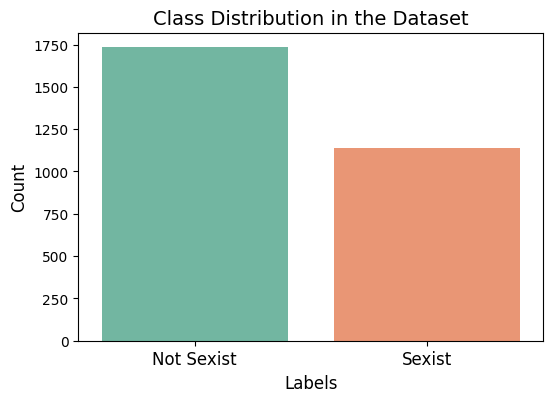

In [139]:
plt.figure(figsize=(6, 4))
sns.countplot(x='hard_label_task1', data=train_df, palette='Set2')

plt.title('Class Distribution in the Dataset', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Not Sexist', 'Sexist'], fontsize=12)
plt.show()

Let's now show the FNR and FPR.

In [144]:
def calculate_rates(cm):
    TN, FP, FN, TP = cm.ravel()
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    return FPR, FNR

fpr_lstm, fnr_lstm = calculate_rates(cm_lstm)
fpr_transformer, fnr_transformer = calculate_rates(cm_transformer)

print(f"LSTM Model:")
print(f"  False Positive Rate (FPR): {fpr_lstm:.2f}")
print(f"  False Negative Rate (FNR): {fnr_lstm:.2f}")

print(f"\nTransformer Model:")
print(f"  False Positive Rate (FPR): {fpr_transformer:.2f}")
print(f"  False Negative Rate (FNR): {fnr_transformer:.2f}")

LSTM Model:
  False Positive Rate (FPR): 0.24
  False Negative Rate (FNR): 0.26

Transformer Model:
  False Positive Rate (FPR): 0.21
  False Negative Rate (FNR): 0.18


As shown by the bar chart, the training set is consistently imbalanced, with a bias toward the "Non-Sexist" class. Imbalanced data can lead to poorer performance, particularly for the minority "Sexist" class, in both the LSTM and pre-trained RoBERTa models. By analyzing the False Positive Rates (FPR) and False Negative Rates (FNR), we can see that the model most affected by the class imbalance is the LSTM model, while the Transformer model is less sensitive to this issue.

Possible solutions to address the imbalance include oversampling the minority class, adding class weights, or applying data augmentation.

**OOV words** could be another reason for the RoBERTa model outperforming the LSTM model. Its dynamic embeddings allow the RoBERTa model to better capture context compared to the GloVe embeddings used in the LSTM. Additionally, RoBERTa can break down words into subword units, whereas the LSTM uses word-level tokenization, which limits the model's ability to understand even smaller parts of words.

There are several solutions to help LSTM-based models better handle OOV words, such as using dynamic embeddings, domain-specific embeddings for social media language, or employing subword tokenization.

Both models suffer from **overfitting** despite using dropout, weight decay and early stopping due to several reasons. One possibility is that the training dataset might be too small or not diverse enough, leading the models to memorize specific patterns rather than generalize well. Another reason could be the model’s high complexity relative to the size of the dataset, where too many parameters are learned, making the model prone to overfitting. 

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End